# CSII 2025 Exercise 04: State Feedback with Luenberger Observer

© 2025 ETH Zurich, Niclas Scheuer, Oscar von Lohneysen, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Authors:
- Niclas Scheuer
- Oscar von Lohneysen

# Automatic Orbital Landing

You part of a European launch provider specializing on high-frequency transports between the moon surface and an orbital station. 

As part of this service, your company has established a fledgling moon base which includes a landing/launch tower. While the algorithm to decelerate the rocket out of orbit towards the launch site is already complete, the final landing burn sequence has not yet been designed. 

## Your rocket: Halogen I
The lander "Halogen I" is a 5 x 2 x 2m vehicle with a maximum payload of 1000kg and total weight up to 1800kg. It possesses a 4000N full-flow staged combustion engine with a TVC (thrust-vector control) rig to angle the engine. 

### Control Inputs:
- $T$:          Thrust generated by the engine [0 - 4000N]
- $\varphi$:    TVC orientation of the engine

### Observable Outputs:
The landing zone is equipped with a long-range motion capture system, which together with the sensors on the rocket, give you access to the following measurements:
- $x$:          Horizontal position of the rocket (meters)
- $y$:          Altitude of the rocket (meters)
- $\theta$:     Angle of the rocket (radians)

### Goal:
The goal is to land the rocket into the clamps of the launch tower (green) while remaining below 1 m/s. Collision with the ground and tower assembly is to be avoided. 

# I: Manual Control
Try manually landing the rocket into the clamps of the launch tower.

In [5]:
import numpy as np

m, I, g, l_1, T_max = 50, 2.5, 1.62, 0.5, 150

def update_true_state(X, T, phi, dt, dynamics_fn):
    """
    Update the simulation state X using RK4 integration.
    
    Parameters:
      - X: current state vector.
      - T: thrust input (N).
      - phi: nozzle angle (rad).
      - dt: time step.
      - dynamics_fn: function handle that computes dX/dt given (X, T, phi).
      
    Returns the updated state vector.
    """
    k1 = dynamics_fn(X, T, phi)
    k2 = dynamics_fn(X + 0.5 * dt * k1, T, phi)
    k3 = dynamics_fn(X + 0.5 * dt * k2, T, phi)
    k4 = dynamics_fn(X + dt * k3, T, phi)
    return X + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def nonlinear_dynamics(X, T, phi):
    x, x_dot, y, y_dot, theta, theta_dot = X
    x_ddot = (T * np.sin(theta + phi)) / m
    # Adjust the gravity direction to ensure upward thrust counteracts gravity.
    y_ddot = (T * np.cos(theta + phi)) / m - g  # Corrected gravity application
    theta_ddot = (T * np.sin(phi) * l_1) / I
    return np.array([x_dot, x_ddot, y_dot, y_ddot, theta_dot, theta_ddot])

def check_landing(X, lander_shape, tower_x, tower_width, tower_height, pad_x, pad_y, pad_size):
    """
    Check for landing or collision conditions.
    
    Parameters:
      - X: state vector [x, x_dot, y, y_dot, theta, theta_dot].
      - lander_shape: 2xN array of lander vertex coordinates (in local frame).
      - tower_x, tower_width, tower_height: tower parameters.
      - pad_x, pad_y, pad_size: landing pad (green square) parameters.
    
    Returns a tuple (game_over, game_result) where:
      - game_over is True if a landing (success or failure) occurred.
      - game_result is a string indicating the result:
          * "failure (out of bounds)"
          * "failure (crashed on ground)"
          * "failure (hit tower)"
          * "success"
          * None if no condition met.
    """
    x_pos, x_dot, altitude, y_dot, theta, theta_dot = X
    # Out-of-bounds horizontally.
    if x_pos > 5 or x_pos < -5:
        return True, "failure (out of bounds)"
    # Ground collision.
    if altitude <= 0:  # Ensure that the altitude is non-positive for ground collision
        return True, "failure (crashed on ground)"
    
    # Compute rotated lander vertices in world coordinates.
    R = np.array([[np.cos(-theta), -np.sin(-theta)],
                  [np.sin(-theta), np.cos(-theta)]])
    lander_world = (R @ lander_shape) + np.array([[x_pos], [altitude]])
    
    # Tower rectangle: (x_min, y_min, x_max, y_max).
    tower_rect = (tower_x - tower_width/2, 0, tower_x + tower_width/2, tower_height)
    for i in range(lander_world.shape[1]):
        pt = (lander_world[0, i], lander_world[1, i])
        if (tower_rect[0] <= pt[0] <= tower_rect[2]) and (tower_rect[1] <= pt[1] <= tower_rect[3]):
            return True, "failure (hit tower)"
    
    # Landing pad rectangle: (pad_x, pad_y, pad_x+pad_size, pad_y+pad_size).
    pad_rect = (pad_x, pad_y, pad_x + pad_size, pad_y + pad_size)
    inside_pad = all((pad_rect[0] <= lander_world[0, i] <= pad_rect[2] and
                      pad_rect[1] <= lander_world[1, i] <= pad_rect[3])
                     for i in range(lander_world.shape[1]))
    # Successful landing if the entire lander is on the pad and the velocities are small.
    if inside_pad and abs(x_dot) < 0.2 and abs(y_dot) < 0.2:
        return True, "success"
    
    return False, None

FloatSlider(value=81.0, description='Thrust T (N):', max=150.0)

FloatSlider(value=0.0, description='Nozzle φ (rad):', max=0.1, min=-0.1, step=0.001)

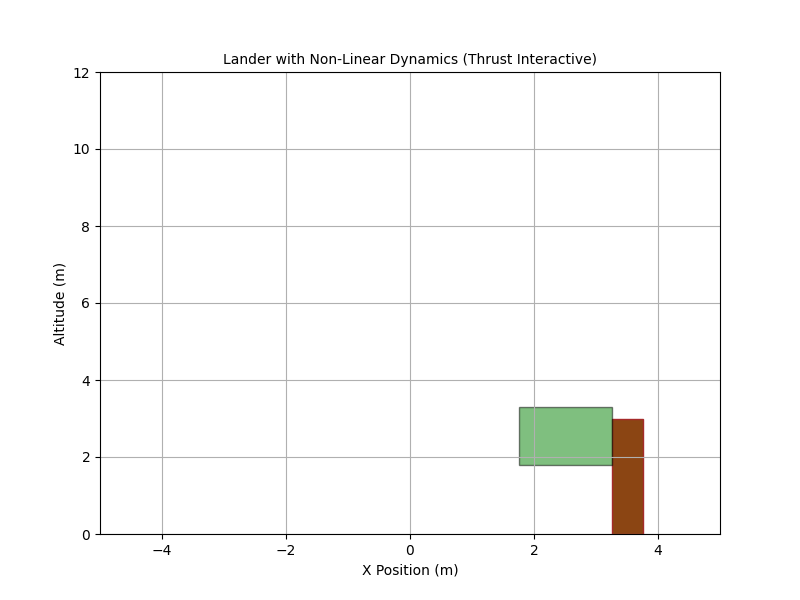

In [6]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display
import time

plt.close('all')

# ---------------------------
# System and Simulation Setup
# ---------------------------
dt = 0.05
T_total = 120
steps = int(T_total / dt)

# State vector: [x, x_dot, y, y_dot, theta, theta_dot]
X = np.zeros(6)
X[2] = 10  # Start altitude at 10 m
X[3] = 0   # Initial vertical velocity should be zero (to maintain equilibrium)

game_over = False
game_result = None

# ---------------------------
# Plot Setup (Unique fig/ax)
# ---------------------------
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.set_xlim(-5, 5)
ax1.set_ylim(0, 12)
ax1.set_xlabel("X Position (m)")
ax1.set_ylabel("Altitude (m)")
ax1.set_title("Lander with Non-Linear Dynamics (Thrust Interactive)", fontsize=10)
ax1.grid(True)

lander_shape = np.array([[-0.4, 0.4, 0.4, -0.4, -0.4],
                         [-0.6, -0.6, 0.6, 0.6, -0.6]])
lander_body, = ax1.plot([], [], 'ks-', lw=2, markersize=8, markerfacecolor='k')
nozzle_plot, = ax1.plot([], [], 'r-', lw=2)

# ---------------------------
# Tower and Landing Pad
# ---------------------------
tower_x, tower_width, tower_height = 3.5, 0.5, 3.0
pad_size = 1.5
lander_height_bbox = 1.2

ax1.add_patch(patches.Rectangle((tower_x - tower_width/2, 0), tower_width, tower_height,
                                linewidth=1, edgecolor='brown', facecolor='saddlebrown'))

pad_x = (tower_x - tower_width/2) - pad_size
pad_y = tower_height - lander_height_bbox
ax1.add_patch(patches.Rectangle((pad_x, pad_y), pad_size, pad_size,
                                linewidth=1, edgecolor='black', facecolor='green', alpha=0.5))

# ---------------------------
# Widgets
# ---------------------------
thrust_slider = widgets.FloatSlider(value=m * g, min=0, max=T_max, step=0.1, description='Thrust T (N):')
phi_slider = widgets.FloatSlider(value=0, min=-0.1, max=0.1, step=0.001, description='Nozzle φ (rad):')
display(thrust_slider, phi_slider)

# ---------------------------
# Timing
# ---------------------------
start_wall_time = time.perf_counter()
sim_time = 0.0

# ---------------------------
# Animation Update
# ---------------------------
def update1(frame):
    global X, sim_time, game_over, game_result
    if game_over:
        return lander_body, nozzle_plot

    real_elapsed = time.perf_counter() - start_wall_time
    while sim_time < real_elapsed and not game_over:
        T_val = thrust_slider.value
        phi_val = phi_slider.value
        X[:] = update_true_state(X, T_val, phi_val, dt, nonlinear_dynamics)
        sim_time += dt
        game_over, game_result = check_landing(X, lander_shape, tower_x, tower_width,
                                               tower_height, pad_x, pad_y, pad_size)

    x_pos, altitude, theta = X[0], X[2], X[4]
    R = np.array([[np.cos(-theta), -np.sin(-theta)],
                  [np.sin(-theta), np.cos(-theta)]])
    lander_coords = R @ lander_shape
    lander_body.set_data(lander_coords[0, :] + x_pos, lander_coords[1, :] + altitude)

    nozzle_base = np.array([0, -lander_height_bbox / 2])
    nozzle_tip = nozzle_base + np.array([np.sin(phi_slider.value), -np.cos(phi_slider.value)]) * 1.0
    nozzle_world_base = R @ nozzle_base + np.array([x_pos, altitude])
    nozzle_world_tip = R @ nozzle_tip + np.array([x_pos, altitude])
    nozzle_plot.set_data([nozzle_world_base[0], nozzle_world_tip[0]], 
                         [nozzle_world_base[1], nozzle_world_tip[1]])

    # Compact title with small font
    status_str = f'Altitude: {altitude:.2f} m | θ: {theta:.2f} rad | φ: {phi_slider.value:.2f} rad'
    if game_over:
        status_str += f" | GAME OVER: {game_result.upper()}"
    ax1.set_title(status_str, fontsize=10)

    return lander_body, nozzle_plot

# ---------------------------
# Start Animation
# ---------------------------
ani = FuncAnimation(fig1, update1, frames=steps, interval=50, blit=True)
plt.show()

# II: Linearized Control

That is pretty difficult no? Let us start working on a controller by understanding the dynamics of the system. 

### Nonlinear Dynamics: 
$$m\ddot{x} = T \cdot \sin(\theta + \varphi)$$
$$m\ddot{y} = mg - T \cdot \cos(\theta + \varphi)$$
$$I \ddot{\theta} = T \cdot \sin(\varphi) \cdot l_1$$

with the following variables:
- $m$: Mass of lander
- $x$: Horizontal position of the lander
- $y$: Vertical position of the lander (positive = down)
- $\theta$: Orientation of the lander
- $l_1$: Distance between nozzle and center of mass
- $T$: Engine thrust
- $varphi$: Engine angle

### Linearizing about the following point:
$x = 0$, $\dot{x} = 0$, $y = 0$, $\dot{y} = 0$, $\theta = 0$, $\dot{\theta} = 0$
$\varphi = 0$, $T = mg$

$$
\begin{bmatrix}
x \\ \dot{x} \\ y \\ \dot{y} \\ \theta \\ \dot{\theta}
\end{bmatrix}'
=
\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & g & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
x \\ \dot{x} \\ y \\ \dot{y} \\ \theta \\ \dot{\theta}
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
0 & g \\
0 & 0 \\
-\frac{1}{m} & 0 \\
0 & 0 \\
0 & \frac{m g l_1}{I}
\end{bmatrix}
\begin{bmatrix}
T \\ \varphi
\end{bmatrix}
$$

$$
y =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
x \\ \dot{x} \\ y \\ \dot{y} \\ \theta \\ \dot{\theta}
\end{bmatrix}
$$

Try controlling the linear system and compare it to the non-linear one. 

In [7]:
A = np.array([[0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, g, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0]])

B = np.array([[0, 0],
              [0, g],
              [0, 0],
              [-1/m, 0],
              [0, 0],
              [0, m * g * l_1 / I]])

C = np.array([[1, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 1, 0]])

def linear_dynamics(X_lin, delta_T, phi):
    u = np.array([delta_T, phi])
    return A @ X_lin + B @ u

def update_linear_state(X_lin, T, phi, dt):
    delta_T = m * g - T  # Linearization deviation
    k1 = linear_dynamics(X_lin, delta_T, phi)
    k2 = linear_dynamics(X_lin + 0.5 * dt * k1, delta_T, phi)
    k3 = linear_dynamics(X_lin + 0.5 * dt * k2, delta_T, phi)
    k4 = linear_dynamics(X_lin + dt * k3, delta_T, phi)
    return X_lin + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

FloatSlider(value=81.0, description='Thrust T (N):', max=150.0)

FloatSlider(value=0.0, description='Nozzle φ (rad):', max=0.1, min=-0.1, step=0.001)

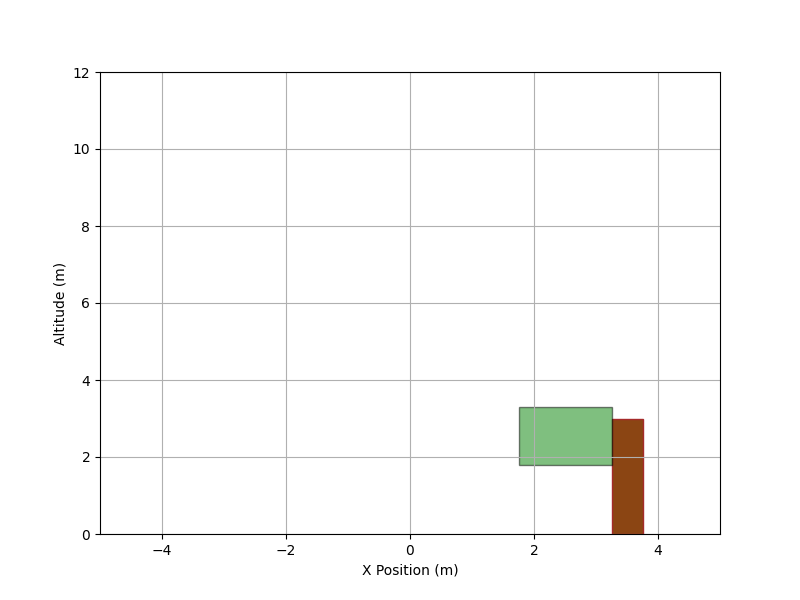

In [8]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display
import time

plt.close('all')

# ---------------------------
# System and Simulation Setup
# ---------------------------
m, I, g, l_1, T_max = 50, 2.5, 1.62, 0.5, 150
dt = 0.05
T_total = 120
steps = int(T_total / dt)

# Initial state for nonlinear and linear systems
X = np.zeros(6)
X[2] = 10  # Start altitude at 10 m
X_lin = np.copy(X)

game_over = False
game_result = None

# ---------------------------
# Plot Setup
# ---------------------------
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(-5, 5)
ax2.set_ylim(0, 12)
ax2.set_xlabel("X Position (m)")
ax2.set_ylabel("Altitude (m)")
ax2.grid(True)

lander_shape = np.array([[-0.4, 0.4, 0.4, -0.4, -0.4],
                         [-0.6, -0.6, 0.6, 0.6, -0.6]])

# Nonlinear lander
lander_body, = ax2.plot([], [], 'ks-', lw=2, markersize=8, markerfacecolor='k')
nozzle_plot, = ax2.plot([], [], 'r-', lw=2)

# Linear lander
lander_body_lin, = ax2.plot([], [], 'bo-', lw=2, markersize=8, markerfacecolor='b')
nozzle_plot_lin, = ax2.plot([], [], 'c-', lw=2)

# ---------------------------
# Tower and Landing Pad
# ---------------------------
tower_x = 3.5
tower_width = 0.5
tower_height = 3.0
pad_size = 1.5
lander_height_bbox = 1.2

ax2.add_patch(patches.Rectangle((tower_x - tower_width / 2, 0), tower_width, tower_height,
                                linewidth=1, edgecolor='brown', facecolor='saddlebrown'))

pad_x = (tower_x - tower_width / 2) - pad_size
pad_y = tower_height - lander_height_bbox
ax2.add_patch(patches.Rectangle((pad_x, pad_y), pad_size, pad_size,
                                linewidth=1, edgecolor='black', facecolor='green', alpha=0.5))

# ---------------------------
# Interactive Widgets
# ---------------------------
thrust_slider = widgets.FloatSlider(value=m * g, min=0, max=T_max, step=0.1, description='Thrust T (N):')
phi_slider = widgets.FloatSlider(value=0, min=-0.1, max=0.1, step=0.001, description='Nozzle φ (rad):')
display(thrust_slider, phi_slider)

start_wall_time = time.perf_counter()
sim_time = 0.0

# ---------------------------
# Animation Update
# ---------------------------
def update2(frame):
    global X, X_lin, sim_time, game_over, game_result
    if game_over:
        return lander_body, nozzle_plot, lander_body_lin, nozzle_plot_lin

    # Get current thrust and nozzle angle
    T_val = thrust_slider.value
    phi_val = phi_slider.value

    # Update nonlinear and linear states
    X[:] = update_true_state(X, T_val, phi_val, dt, nonlinear_dynamics)
    X_lin[:] = update_linear_state(X_lin, T_val, phi_val, dt)
    sim_time += dt

    # Check landing/crash
    game_over, game_result = check_landing(X, lander_shape, tower_x, tower_width, tower_height, pad_x, pad_y, pad_size)

    # ---------------------------
    # Draw Nonlinear Lander
    # ---------------------------
    x_pos, altitude, theta = X[0], X[2], X[4]
    R = np.array([[np.cos(-theta), -np.sin(-theta)],
                  [np.sin(-theta), np.cos(-theta)]])
    lander_coords = R @ lander_shape
    lander_body.set_data(lander_coords[0, :] + x_pos, lander_coords[1, :] + altitude)

    nozzle_base = np.array([0, -lander_height_bbox / 2])
    nozzle_tip = nozzle_base + np.array([np.sin(phi_val), -np.cos(phi_val)]) * 1.0
    nozzle_world_base = R @ nozzle_base + np.array([x_pos, altitude])
    nozzle_world_tip = R @ nozzle_tip + np.array([x_pos, altitude])
    nozzle_plot.set_data([nozzle_world_base[0], nozzle_world_tip[0]], [nozzle_world_base[1], nozzle_world_tip[1]])

    # ---------------------------
    # Draw Linear Lander
    # ---------------------------
    x_pos_lin, altitude_lin, theta_lin = X_lin[0], X_lin[2], X_lin[4]
    R_lin = np.array([[np.cos(-theta_lin), -np.sin(-theta_lin)],
                      [np.sin(-theta_lin), np.cos(-theta_lin)]])
    lander_coords_lin = R_lin @ lander_shape
    lander_body_lin.set_data(lander_coords_lin[0, :] + x_pos_lin, lander_coords_lin[1, :] + altitude_lin)

    nozzle_world_base_lin = R_lin @ nozzle_base + np.array([x_pos_lin, altitude_lin])
    nozzle_world_tip_lin = R_lin @ nozzle_tip + np.array([x_pos_lin, altitude_lin])
    nozzle_plot_lin.set_data([nozzle_world_base_lin[0], nozzle_world_tip_lin[0]], 
                             [nozzle_world_base_lin[1], nozzle_world_tip_lin[1]])

    # ---------------------------
    # Status / Title
    # ---------------------------
    status_str = (f'Altitude: True = {altitude:.2f} m, Linear = {altitude_lin:.2f} m | '
                  f'Theta: True = {theta:.2f} rad, Linear = {theta_lin:.2f} rad')
    if game_over:
        status_str += f' | GAME OVER: {game_result.upper()}'
    ax2.set_title(status_str, fontsize=10)

    return lander_body, nozzle_plot, lander_body_lin, nozzle_plot_lin

# ---------------------------
# Start Animation
# ---------------------------
ani = FuncAnimation(fig2, update2, frames=steps, interval=50, blit=True)
plt.show()


# III: LQG

We will now implement an estimator using LQE to properly update the states of our linearized model $\hat{x}$ to the outputs of the nonlinear model $y$.



In [22]:
from control import lqr
from scipy.linalg import solve_continuous_are

# -------------------------------------------------
# LQE (Observer) Design
# -------------------------------------------------
# Define noise covariances
Q_cov = np.diag([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])  # Process noise covariance
R_cov = np.diag([0.5, 0.5, 0.05])                   # Measurement noise covariance
G = np.eye(6)  # Process noise input matrix

# Solve the continuous-time algebraic Riccati equation (dual form for Kalman filter)
P = solve_continuous_are(A.T, C.T, G @ Q_cov @ G.T, R_cov)
# Compute the observer gain L
L_obs = P @ C.T @ np.linalg.inv(R_cov)
L_obs[np.abs(L_obs) < 1e-10] = 0.0
print("Observer Gain L:\n", L_obs)

# -------------------------------------------------
# LQR Controller Design for Tracking
# -------------------------------------------------
Q_lqr = np.diag([10, 0.1, 10, 0.1, 10, 0.1])
R_lqr = np.diag([0.5, 0.1])
# Compute the LQR gain K (designed on the linearized model)
K_lqr, S, E_lqr = lqr(A, B, Q_lqr, R_lqr)
K_lqr[np.abs(K_lqr) < 1e-10] = 0.0
print("LQR Gain K:\n", K_lqr)
print("Poles of A-BK:", np.linalg.eigvals(A - B @ K_lqr))


Observer Gain L:
 [[1.22840697 0.         0.70631884]
 [0.67943616 0.         1.53019437]
 [0.         1.04614874 0.        ]
 [0.         0.4472136  0.        ]
 [0.07063188 0.         1.02164488]
 [0.00590596 0.         0.44682345]]
LQR Gain K:
 [[  0.           0.          -4.47213595 -21.15215345   0.
    0.        ]
 [ 10.          12.0630089    0.           0.          11.70581089
    0.39950689]]
Poles of A-BK: [-12.15510182+3.87993198j -12.15510182-3.87993198j
  -0.85194121+0.94139886j  -0.85194121-0.94139886j
  -0.21152153+0.21142696j  -0.21152153-0.21142696j]


Creating the new observer dynamics below:

$$\dot{\hat{x}} = A\hat{x} + Bu + L*(y_{meas} - C*\hat{x})$$

In [23]:
def observer_dynamics(xhat, u, y, A, B, C, L):
    """
    Computes the derivative of the state estimate xhat.

    xhat_dot = A*xhat + B*u + L*(y - C*xhat) + np.array([0, 0, 0, g, 0, 0])

    Parameters:
      xhat: state estimate vector (6,)
      u: control input vector (2,)
      y: measurement vector (3,)
      A, B, C: system matrices
      L: observer gain matrix

    Returns:
      xhat_dot: derivative of the state estimate
    """
    # Gravity is added to the vertical acceleration, as gravity acts downward
    return A @ xhat + B @ u + L @ (y - C @ xhat) + np.array([0, 0, 0, g, 0, 0])

def update_observer_state(X_hat, u, y_meas, dt):
    k1 = observer_dynamics(X_hat, u, y_meas, A, B, C, L_obs)
    k2 = observer_dynamics(X_hat + 0.5 * dt * k1, u, y_meas, A, B, C, L_obs)
    k3 = observer_dynamics(X_hat + 0.5 * dt * k2, u, y_meas, A, B, C, L_obs)
    k4 = observer_dynamics(X_hat + dt * k3, u, y_meas, A, B, C, L_obs)
    return X_hat + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


Finally, the system is estimated and stabilized using the LQG controller. Now you can slide the references to move the lander. 

Note the following: 
- We do not know the position of the real lander, we are using the linear model to approximate it
- Unlike the above example, the observer allows us to correct errors in the linear model
- The linear model, granted it is close enough to the nonlinear one, gives us estimated states for state feedback

Startup!


FloatSlider(value=0.0, description='r_x:', max=5.0, min=-5.0)

FloatSlider(value=10.0, description='r_y:', max=12.0, step=0.01)

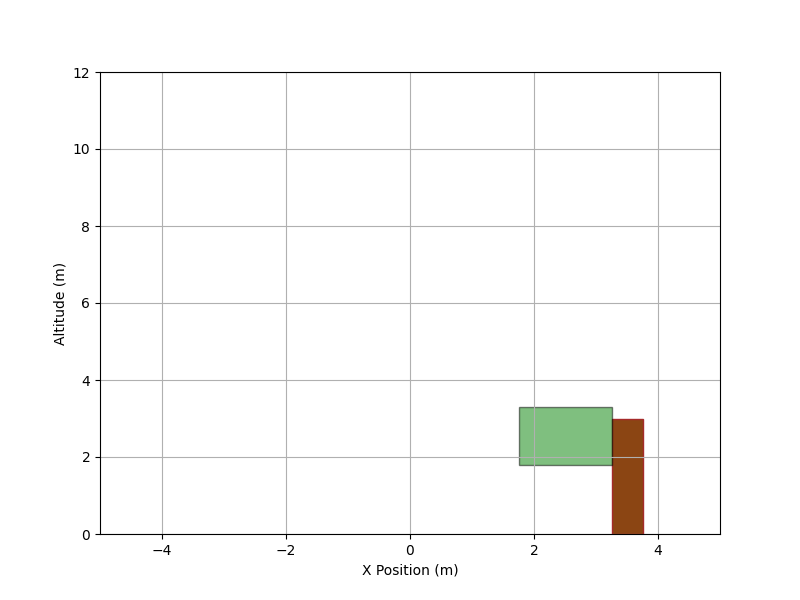

In [ ]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display
import time
import gc

try:
    ani.event_source.stop()
    del ani
except:
    pass
plt.close('all') 
gc.collect()
print("Startup!")

# ---------------------------
# System and Simulation Setup
# ---------------------------
m, I, g, l_1, T_max = 50, 2.5, 1.62, 0.5, 150
dt = 0.05
T_total = 120
steps = int(T_total / dt)

X = np.zeros(6)
X[2] = 10  # Start altitude at 10 m
X_hat = np.copy(X)

game_over = False
game_result = None

# ---------------------------
# Plot Setup
# ---------------------------
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.set_xlim(-5, 5)
ax3.set_ylim(0, 12)
ax3.set_xlabel("X Position (m)")
ax3.set_ylabel("Altitude (m)")
ax3.grid(True)

lander_shape = np.array([[-0.4, 0.4, 0.4, -0.4, -0.4],
                         [-0.6, -0.6, 0.6, 0.6, -0.6]])

lander_body, = ax3.plot([], [], 'ks-', lw=2, markersize=8, markerfacecolor='k')
nozzle_plot, = ax3.plot([], [], 'r-', lw=2)

lander_body_lin, = ax3.plot([], [], 'bo-', lw=2, markersize=8, markerfacecolor='b')
nozzle_plot_lin, = ax3.plot([], [], 'c-', lw=2)

ref_marker, = ax3.plot([], [], 'r*', markersize=12, label='Reference')

# ---------------------------
# Tower and Landing Pad
# ---------------------------
tower_x = 3.5
tower_width = 0.5
tower_height = 3.0
pad_size = 1.5
lander_height_bbox = 1.2

ax3.add_patch(patches.Rectangle((tower_x - tower_width / 2, 0), tower_width, tower_height,
                                linewidth=1, edgecolor='brown', facecolor='saddlebrown'))

pad_x = (tower_x - tower_width / 2) - pad_size
pad_y = tower_height - lander_height_bbox
ax3.add_patch(patches.Rectangle((pad_x, pad_y), pad_size, pad_size,
                                linewidth=1, edgecolor='black', facecolor='green', alpha=0.5))

T_val = m*g
phi_val = 0.0
# ---------------------------
# Interactive Widgets
# ---------------------------
r_x_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='r_x:')
r_y_slider = widgets.FloatSlider(value=10, min=0, max=12, step=0.01, description='r_y:')
display(r_x_slider, r_y_slider)

start_wall_time = time.perf_counter()
sim_time = 0.0

# ---------------------------
# Animation Update
# ---------------------------
def update3(frame):
    global X, X_hat, sim_time, game_over, game_result
    if game_over:
        return lander_body, nozzle_plot, lander_body_lin, nozzle_plot_lin, ref_marker

    r_x = r_x_slider.value
    r_y = r_y_slider.value

    X_ref = np.array([r_x, 0.0, r_y, 0.0, 0.0, 0.0])

    u_eq = np.array([1.2 * m * g, 0.0])  # Hover thrust to counteract gravity (no torque)
    u_lqr = K_lqr @ (X_hat - X_ref)  # LQR control law

    # Flip the sign of the first element (thrust control)
    u_lqr[0] = -u_lqr[0]

    u = u_eq - u_lqr

    T_val = u_eq[0]
    phi_val = u_eq[1]
    X[:] = update_true_state(X, T_val, phi_val, dt, nonlinear_dynamics)
    Y = C @ X
    X_hat[:] = update_observer_state(X_hat, u, Y, dt)
    sim_time += dt

    # Check landing/crash
    game_over, game_result = check_landing(X, lander_shape, tower_x, tower_width, tower_height, pad_x, pad_y, pad_size)

    # Draw Nonlinear Lander
    x_pos, altitude, theta = X[0], X[2], X[4]
    R = np.array([[np.cos(-theta), -np.sin(-theta)],
                  [np.sin(-theta), np.cos(-theta)]])
    lander_coords = R @ lander_shape
    lander_body.set_data(lander_coords[0, :] + x_pos, lander_coords[1, :] + altitude)

    nozzle_base = np.array([0, -lander_height_bbox / 2])
    nozzle_tip = nozzle_base + np.array([np.sin(phi_val), -np.cos(phi_val)]) * 1.0
    nozzle_world_base = R @ nozzle_base + np.array([x_pos, altitude])
    nozzle_world_tip = R @ nozzle_tip + np.array([x_pos, altitude])
    nozzle_plot.set_data([nozzle_world_base[0], nozzle_world_tip[0]],
                         [nozzle_world_base[1], nozzle_world_tip[1]])

    # Draw Linear Lander
    x_pos_lin, altitude_lin, theta_lin = X_hat[0], X_hat[2], X_hat[4]
    R_lin = np.array([[np.cos(-theta_lin), -np.sin(-theta_lin)],
                      [np.sin(-theta_lin), np.cos(-theta_lin)]])
    lander_coords_lin = R_lin @ lander_shape
    lander_body_lin.set_data(lander_coords_lin[0, :] + x_pos_lin, lander_coords_lin[1, :] + altitude_lin)

    nozzle_world_base_lin = R_lin @ nozzle_base + np.array([x_pos_lin, altitude_lin])
    nozzle_world_tip_lin = R_lin @ nozzle_tip + np.array([x_pos_lin, altitude_lin])
    nozzle_plot_lin.set_data([nozzle_world_base_lin[0], nozzle_world_tip_lin[0]],
                             [nozzle_world_base_lin[1], nozzle_world_tip_lin[1]])

    # --- Update Reference Marker ---
    ref_marker.set_data([r_x], [r_y])

    # ---------------------------
    # Status / Title
    # ---------------------------
    status_str = (f'Altitude: True = {altitude:.2f} m, Linear = {altitude_lin:.2f} m | '
                  f'Theta: True = {theta:.2f} rad, Linear = {theta_lin:.2f} rad')
    if game_over:
        status_str += f' | GAME OVER: {game_result.upper()}'
    ax3.set_title(status_str, fontsize=10)

    return lander_body, nozzle_plot, lander_body_lin, nozzle_plot_lin, ref_marker

# ---------------------------
# Start Animation
# ---------------------------
ani = FuncAnimation(fig3, update3, frames=steps, interval=50, blit=False)
plt.show()
